## LAB - 10
**Name - Mohammed Abuzar Younus**<br>
**Student ID - 8903244**

**Obtain the Data**<br>
Download the BIRDS 525 SPECIES dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks.<br>
Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (ImageDataGenerator.flow_from_directory).<br>
For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others

In [143]:
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from PIL import Image


In [144]:
# Assuming the path is on Windows, use double backslashes or raw strings
data_folder = pathlib.Path("C:\\Users\\user\\Desktop\\ML foundation\\CSCN8010-lab-submissions\\students_submissions\\8903244")

# Create ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(rescale=1.0/255)
# Define the relative paths to the train, validation, and test sets
train_dir = data_folder / "train"
valid_dir = data_folder / "valid"
test_dir = data_folder / "test"

# Loading the training dataset
train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary')


# dict to store image count for each class
image_count = {}

# Loop through sub directories and update the count for each class
for species in os.listdir(train_dir):
    species_path = os.path.join(train_dir, species)
    if os.path.isdir(species_path):
        image_count[species] = len(os.listdir(species_path))

# sort the dictionary to list 3 top class
top_3_class = sorted(image_count, key=image_count.get, reverse=True)[:3]

print('Top 3 class with highest number of images:', top_3_class)

Found 744 images belonging to 3 classes.
Top 3 class with highest number of images: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [145]:
# delete other directories for train folder
for species in os.listdir(train_dir):
    if species not in top_3_class:
        delete_path_train = os.path.join(train_dir, species)
        shutil.rmtree(delete_path_train)

# delete other directories for test folder
for species in os.listdir(test_dir):
    if species not in top_3_class:
        delete_path_test = os.path.join(test_dir, species)
        shutil.rmtree(delete_path_test)

# delete other directories for valid folder
for species in os.listdir(valid_dir):
    if species not in top_3_class:
        delete_path_valid = os.path.join(valid_dir, species)
        shutil.rmtree(delete_path_valid)

In [146]:
print('Train folder after deletion:', os.listdir(train_dir))
print('Test folder after deletion:', os.listdir(test_dir))
print('Validation folder after deletion:', os.listdir(valid_dir))


Train folder after deletion: ['D-ARNAUDS BARBET', 'HOUSE FINCH', 'RUFOUS TREPE']
Test folder after deletion: ['D-ARNAUDS BARBET', 'HOUSE FINCH', 'RUFOUS TREPE']
Validation folder after deletion: ['D-ARNAUDS BARBET', 'HOUSE FINCH', 'RUFOUS TREPE']


**2 .Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.**

In [147]:
# Create ImageDataGenerator for data augmentation and preprocessing
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    fill_mode='nearest'
)


# Loading the training dataset
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Loading the validation dataset
validation_generator = data_generator.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Loading the test dataset
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


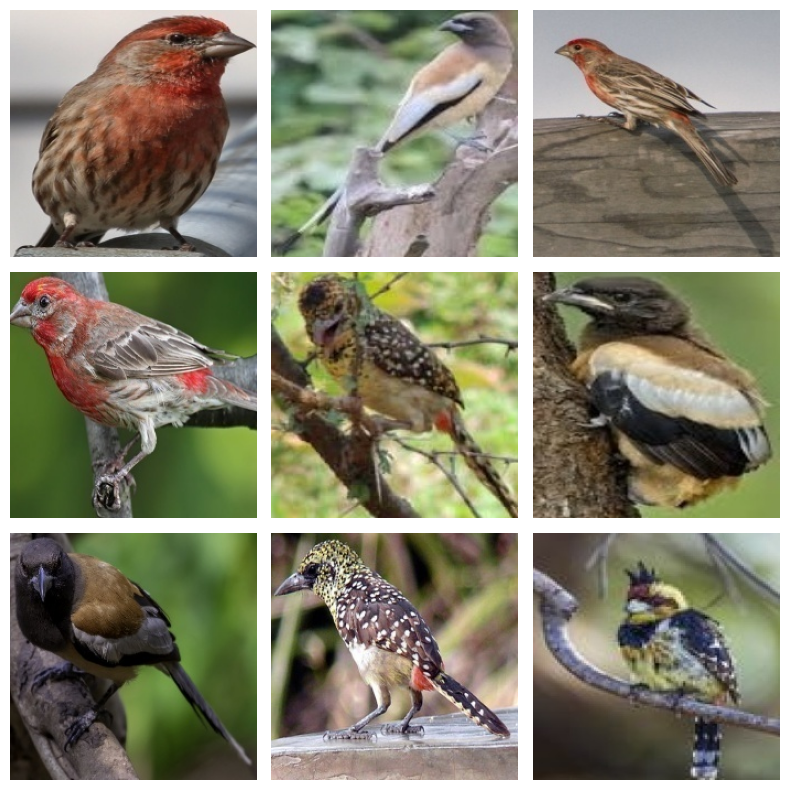

In [148]:
# Display some augmented training images in a 3x3 grid
plt.figure(figsize=(8, 8))
for i in range(9):
    image, label = train_generator.next()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0].astype("uint8"))
    plt.axis("off")
plt.tight_layout()
plt.show()

**3 . Fine-Tune VGG16 (pre-trained on imagenet), to classify the 3 classes**

In [149]:
# load pre-trained VGG16 model from imagenet
model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [150]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [151]:
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [152]:
# Add custom layers
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# 3 classes
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model_1 = Model(inputs=model.input, outputs=predictions)

In [153]:
model_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [154]:
# freeze all layers of pretrained model for fine-tuning
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [155]:
model_1.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate = 1e-5), 
              metrics=['accuracy'])

In [156]:


# Custom file path where the best model will be saved
custom_file_path = "C:\\Users\\user\\Desktop\\ML foundation\\CSCN8010-lab-submissions\\students_submissions\\8903244\\best_model.h5"

# Create the directory path if it does not exist
directory = os.path.dirname(custom_file_path)
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the callback with the custom file path
callbacks = [
    ModelCheckpoint(
        filepath=custom_file_path,
        save_best_only=True,
        monitor="val_loss"
    )
]



In [157]:
history = model_1.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10


24/24 [==============================] - 65s 3s/step - loss: 7.3518 - accuracy: 0.4113 - val_loss: 4.7415 - val_accuracy: 0.4667
Epoch 2/10


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 55s 2s/step - loss: 6.0897 - accuracy: 0.3723 - val_loss: 3.3287 - val_accuracy: 0.4667
Epoch 3/10
24/24 [==============================] - 52s 2s/step - loss: 5.3055 - accuracy: 0.4234 - val_loss: 2.1688 - val_accuracy: 0.5333
Epoch 4/10
24/24 [==============================] - 54s 2s/step - loss: 4.7338 - accuracy: 0.4341 - val_loss: 1.7621 - val_accuracy: 0.5333
Epoch 5/10
24/24 [==============================] - 58s 2s/step - loss: 4.3775 - accuracy: 0.4825 - val_loss: 1.2360 - val_accuracy: 0.5333
Epoch 6/10
24/24 [==============================] - 61s 3s/step - loss: 3.6855 - accuracy: 0.5040 - val_loss: 0.8728 - val_accuracy: 0.6667
Epoch 7/10
24/24 [==============================] - 59s 2s/step - loss: 3.2261 - accuracy: 0.5941 - val_loss: 0.5542 - val_accuracy: 0.6667
Epoch 8/10
24/24 [==============================] - 59s 2s/step - loss: 2.6980 - accuracy: 0.6183 - val_loss: 0.3456 - val_accuracy: 0.8000
Epoch 9/10
24/24 [=============

In [158]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

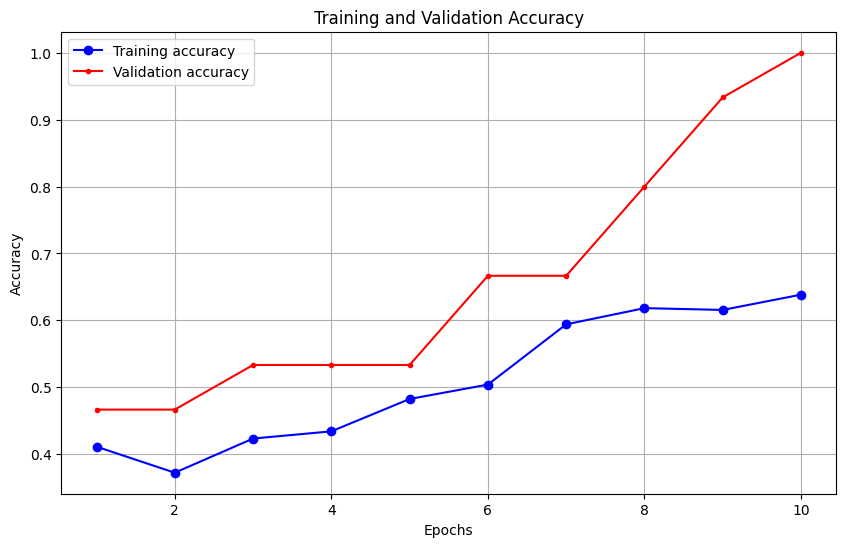

In [159]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, "bo-", label="Training accuracy")
plt.plot(epochs, val_acc, "r.-", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

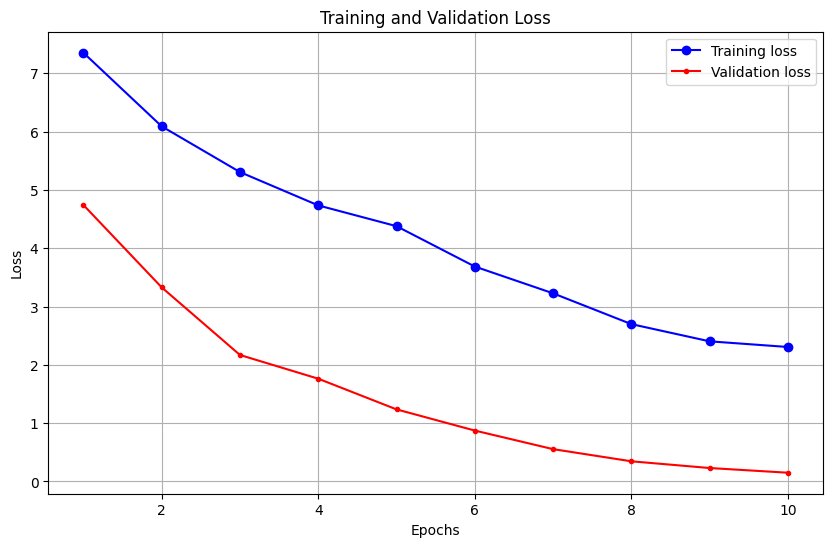

In [160]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, "bo-", label="Training loss")
plt.plot(epochs, val_loss, "r.-", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [166]:
# evaluating the performance of the model on a test dataset.
val_loss, val_acc = model_1.evaluate(validation_generator)
test_loss, test_acc = model_1.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}\n")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Validation Loss: {val_loss:.3f}")

1/1 [==============================] - 1s 1s/step - loss: 0.0467 - accuracy: 1.0000
Test accuracy: 1.000
Test Loss: 0.047

Validation accuracy: 1.000
Validation Loss: 0.148


 A test accuracy of 1.000 means that the model correctly predicted all the samples in the test dataset, achieving 100% accuracy.<br>
 A validation accuracy of 1.000 also means that the model correctly predicted all the samples in the validation dataset, achieving 100% accuracy during the training process.

In [163]:
# Confusion matrix, Precision, Recall and F1-score
y_pred = model_1.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# precision, recall and F1-score
print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))

1/1 [==============================] - 1s 1s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.20      0.20      0.20         5
     HOUSE FINCH       0.80      0.80      0.80         5
    RUFOUS TREPE       0.40      0.40      0.40         5

        accuracy                           0.47        15
       macro avg       0.47      0.47      0.47        15
    weighted avg       0.47      0.47      0.47        15



A precision of 0.20 for "D-ARNAUDS BARBET" means that out of the samples predicted as "D-ARNAUDS BARBET," only 20% were actually "D-ARNAUDS BARBET."<br>
A recall of 0.20 for "D-ARNAUDS BARBET" means that only 20% of the true "D-ARNAUDS BARBET" samples were correctly identified by the model.<br>
A higher F1-score indicates better overall performance. For example, an F1-score of 0.80 for "HOUSE FINCH" means that the model achieved a good balance between precision and recall for this class.<br>
D-ARNAUDS BARBET" has a support of 5, which means there are 5 samples of "D-ARNAUDS BARBET" in the test dataset.<br>
The overall accuracy of the model on all classes is 0.47, which means the model correctly predicted 47% of the samples in the test dataset.<br>


AUC for D-ARNAUDS BARBET: 0.23529304029304027
AUC for HOUSE FINCH: 0.8930952380952379
AUC for RUFOUS TREPE: 0.2816133866133866


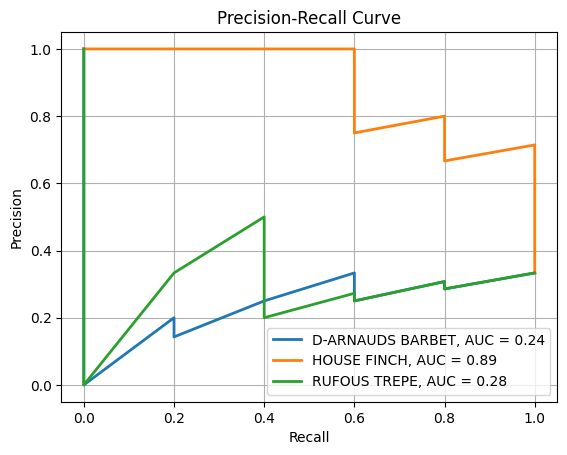

In [164]:
# convert true labels to one-hot encoding for multi-class
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# Plot settings

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

**Some example of missclassified species**

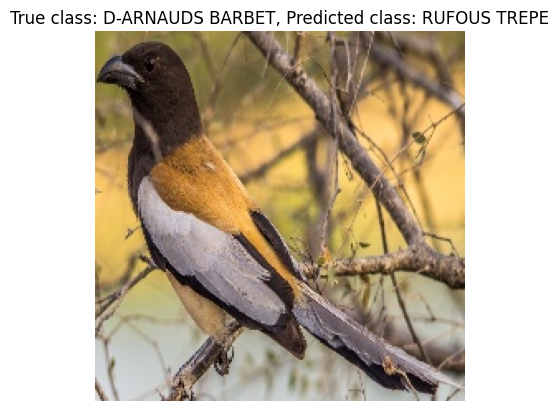

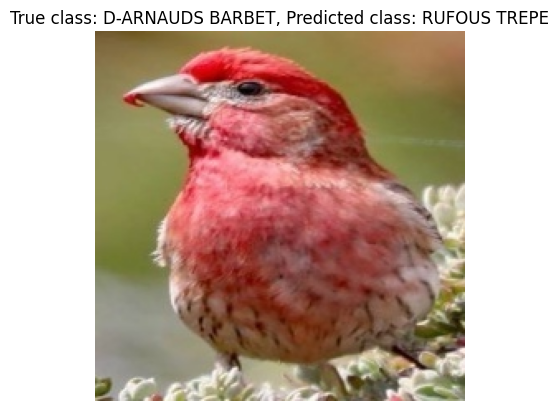

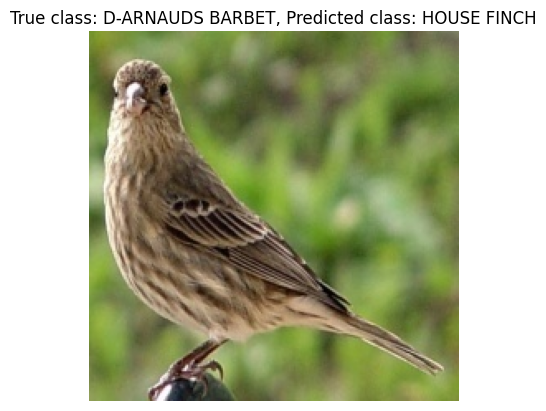

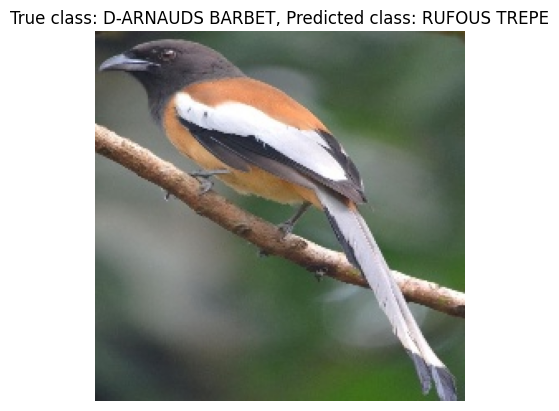

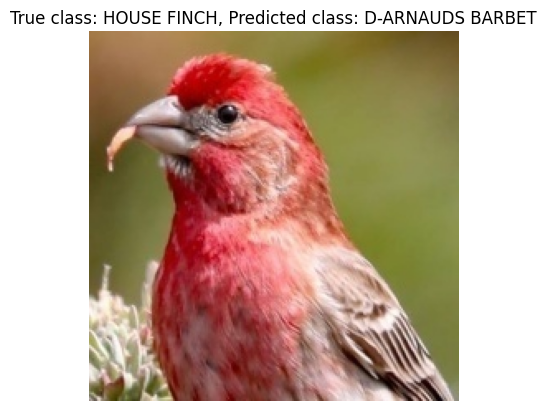

In [165]:
# explore incorrectly predicted examples
misclassfied_index = np.where(y_pred_class != y_true)[0]

# plot specific examples
for index in misclassfied_index[:5]:
    # get image from corresponding batch
    img_batch, _ = validation_generator[index // validation_generator.batch_size]
    img = img_batch[index % validation_generator.batch_size]
    
    true_class_name = class_names[y_true[index]]
    predicted_class_name = class_names[y_pred_class[index]]

    plt.imshow(img.astype('uint8'))
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()